# Bloco De Análise de Modelos Cosmológicos e Geração de Cadeias

Nesse $\textit{notebook}$ serão:

- Gerados parâmetros com Método dos Mínimos Quadrados (para o modelo padrão $\Lambda CDM$) e com o Teste de $\Chi^2$ (para ambos os modelos)
- As cadeias que serão usadas para o trabalho estatístico dos intervalos de credibilidade a serem adicionados no plotting.
- Plotting das Cadeias
- Análise da Cadeia por meio de summary (dicionário) para obtenção do intervalo de credibilidade e do centro da distribuição para bestfit 
- Salvamento das Cadeias para uso na Análise de Identificabilildade 
- Plotting dos Gráficos 2D dos modelos cosmológicos com seus parâmetros obtidos no Método dos Mínimos Quadrados, Máxima Verossimilhança (Likelihood) e do Best Fit após análise da Cadeia  

 # Definição dos Modelos Cosmolǵicos

 - Modelo Padrão $\Lambda CDM$ com dois parâmetros livres:

 (Os parâmetros livres são $H_0$ e $\Omega_{m}$)

 $H = H_0 \sqrt{\left[ \Omega_{\Lambda_0} + \left( 1 - \Omega_{\Lambda_0} - \Omega_{m_0} - \Omega_{r_0}  \right) \left( \frac{a_0}{a} \right)^2 + \Omega_{m_0} \left(\frac{a_0}{a} \right)^3 + \Omega_{r_0} \left( \frac{a_0}{a} \right)^4 \right]}$

- Modelo Cosmológico com interação de fluidos de matéria e energia escura com três parâmetros livres:

(Os parâmetros livres são $H_0$, $\Omega_m$ e $\epsilon$)

$H = H_0 \sqrt{ \Omega_{m_0} \left[ a^{-3 + \epsilon} + \frac{\epsilon}{3 - \epsilon} \left(a^{-3 + \epsilon} - 1 \right) \right] + \Omega_{\Lambda_0} }$


Porém, como o modelo está em função de $z$ tal que $z$ seja o $\textit{redshift}$ e

$a = a(z) = \frac{1}{1 + z}$ e $a_0 = a(0) = 1$

Precisamos reescrever os modelos para que $H$ seja uma função do $\textit{redshift}$ e assumindo a relação $\Omega_{k_0} = 0$, $\Omega_{r_0} = 0$ (Densidade de Curvatura nulo num universo aproximadamente plano), $\Omega_{r_0}$ e $\Omega_{\Lambda} = 1 - \Omega_{m_0}$. Mas, vamos deixar as relações de densidade serem explor_adas dentro da definição das funções no código:

- Para o Modelo Padrão $\Lambda CDM$


$H(z) = H_0 \sqrt{\left[ \Omega_{\Lambda} + \Omega_{k_0} \left( 1+z \right)^2 + \Omega_{m_0} \left( 1+z \right)^3 + \Omega_{r_0} \left( 1+z \right)⁴ \right] }$

- Para o Modelo Modificado com fluidos de interação de energia e matéria escura:

$H(z) = H_0 \sqrt{\Omega_{m_0} \left[ \left(1+z \right)^{3 - \epsilon} + \frac{\epsilon}{3 - \epsilon} \left( \left(1+z \right)^{3-\epsilon} - 1 \right) \right] + \Omega_{\Lambda_0} }$


- Configuração de Plotting

In [2]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['savefig.dpi'] = 100
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 20

- Bibliotecas

In [12]:
import numpy as np
import pandas as pd
import emcee
import tqdm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer, Truth, ChainConfig, PlotConfig
from jax import random
from numpyro.infer import mcmc, NUTS
from scipy.stats import norm
import arviz as az

- Definição das Funções para o código

In [18]:
#Modelo Padrão \Lambda CDM

def StandardModel(z, H0, Omega_m0):
    Omega_k0 = 0
    Omega_L = 1 - Omega_m0
    Omega_r0 = 0
    H_LCDM = H0*(Omega_L + Omega_k0 * (1+z)**2 + Omega_m0* (1+z)**3 + Omega_r0*(1+z)**4)**(1/2)
    return H_LCDM

#Modelo Modificado com interação entre Matéria Escura e Energia Escura 
def DarkMatterEnergyInteractionModel(z, H0, Omega_m0, epsilon):
    Omega_L0 = 1 - Omega_m0
    H_Modified = H0*(Omega_m0*((1.0 + z)**(3.0 - epsilon) + (epsilon/(3.0 - epsilon))*((1.0+z)**(3.0 - epsilon)-1.0))+ Omega_L0)**(1/2)
    return H_Modified

#Função de Verossimilhança para Modelo Padrão (2 parâmetros Livres)
def log_likelihood_StandardModel(theta, z_data, H_observed, errodata):
    H0, Omega_m0 = theta
    H_predicted = StandardModel(z_data, H0, Omega_m0)
    sigma2 = errodata**2
    chi2 = ((H_observed - H_predicted)**2)/sigma2
    return -0.5*np.sum(chi2 + np.log(sigma2))

#Função de Verossimilhança para Modelo Interagente (3 Parâmetros Livres)
def log_likelihood_InteractionModel(theta, z_data, H_observed, errordata):
    H0, Omega_m0, epsilon = theta
    H_predicted = DarkMatterEnergyInteractionModel(z_data, H0, Omega_m0, epsilon)
    sigma2 = errordata**2
    chi2 = ((H_observed - H_predicted)**2)/sigma2
    return -0.5*np.sum(chi2 + np.log(sigma2))

- Definição das Funções para a Cadeia de Markov

OBSERVAÇÃO:
    Essas funções estão separadas para que, caso necessário, mudem-se os intervalos dos parâmetros de acordo com a necessidade e o valor retornado pela função de Máxima Verossimilhança.

    Geralmente, adicionamos ± 10 ou ± 1 para os intervalos de forma que o plotting fique o mais centralizado possível

In [6]:
#Função para distribuição a priori para a construção da Cadeia de Markov no modelo de dois parâmetros livres
def log_prior_StandardModel(theta):
    H0, Omega_m0 = theta
    if 60.0 < H0 < 80.0 and 0.2 < Omega_m0 < 0.38: #and -10.0 < log_alpha < 1.0:
        return 0.0
    return -np.inf

#Função para distribuição a priori para a construção da Cadeia de Markov no modelo de três parâmetros livres 
def log_prior_InteractionModel(theta):
    H0, Omega_m0, epsilon = theta
    if 62.0 < H0 < 75.0 and 0.0 < Omega_m0 < 0.90 and -1.07 < epsilon < 1.00: #and -10.0 < log_alpha < 1.0:
        return 0.0
    return -np.inf

#Função de distribuição de probabilidade para a Cadeia e de dois parâmetros livres
def log_probability_StandardModel(theta, x, y, yerr):
    lp = log_prior_StandardModel(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_StandardModel(theta, x, y, yerr)



#Função de distribuição de probabilidade para a Cadeia e de dois parâmetros livres
def log_probability_InteractionModel(theta, x, y, yerr):
    lp = log_prior_InteractionModel(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_InteractionModel(theta, x, y, yerr)

- Alocação dos Dados Observacionais

In [8]:
ObservationalData = pd.read_csv(r'/home/cordoeira/Documentos/EMCEE/DadosObservacionais/H(z).txt',header= None, sep='\s\s+', engine='python')
ObservationalData.columns = ['z', 'H', 'error_H']
data = pd.DataFrame(ObservationalData)

z_data = ObservationalData['z']
H_data = ObservationalData['H']
z_error = ObservationalData['error_H'].values

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_22451/1403846048.py:1: SyntaxWarning: invalid escape sequence '\s'
  ObservationalData = pd.read_csv(r'/home/cordoeira/Documentos/EMCEE/DadosObservacionais/H(z).txt',header= None, sep='\s\s+', engine='python')


- Alocação dos Paraâmetros Fixos Verdadeiros para análise

In [10]:
H0_true = 67.66
Omega_m0_true = 0.311
epsilon_true = 0.1

# Bloco para Análise do Modelo Padrão $\Lambda CDM$

Nas próximas células, serão feitas as análise preliminares dos parâmetros pelo Método de Mínimos Quadrados e pelo Teste de $\Chi^2$.

---------------------------------------------------------------------------------------------------

- Estimação dos Parâmetros pelo Método dos Mínimos Quadrados

In [14]:
A = np.vander(z_data, 2)
C = np.diag(z_error*z_error)

y = StandardModel(z_data, H0_true, Omega_m0_true)

ATA = np.dot(A.T, A/(z_error*2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y/(z_error*2)))
print('Estimativa de Mínimos Quadrados')
print("H0= {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0,0])))
print("Omega_m0= {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1,1])))


Estimativa de Mínimos Quadrados
H0= 63.661 ± 2.214
Omega_m0= 60.381 ± 1.499


- Estimação dos Parâmetros pelo Teste de $\Chi^2$

In [20]:
nll = lambda *args: - log_likelihood_StandardModel(*args)

initial = np.array([67.66,0.3])
soln = minimize(nll, initial, args=(z_data, H_data, z_error))
H0_ml, Omega_ml = soln.x

print("Máxima Verossimilhança: ")
print("H0 = {0:.3f}".format(H0_ml))
print("Omega_m0 = {0:.3f}".format(Omega_ml))

Máxima Verossimilhança: 
H0 = 68.150
Omega_m0 = 0.320


- Plotting do Modelo $\Lambda CDM$ com os dados Observacionais

<>:6: SyntaxWarning: invalid escape sequence '\L'
<>:6: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_22451/956870215.py:6: SyntaxWarning: invalid escape sequence '\L'
  ax.plot(z_data, StandardModel(z_data, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')


(Text(0.5, 0, '$z$'), Text(0, 0.5, '$H(z)$'))

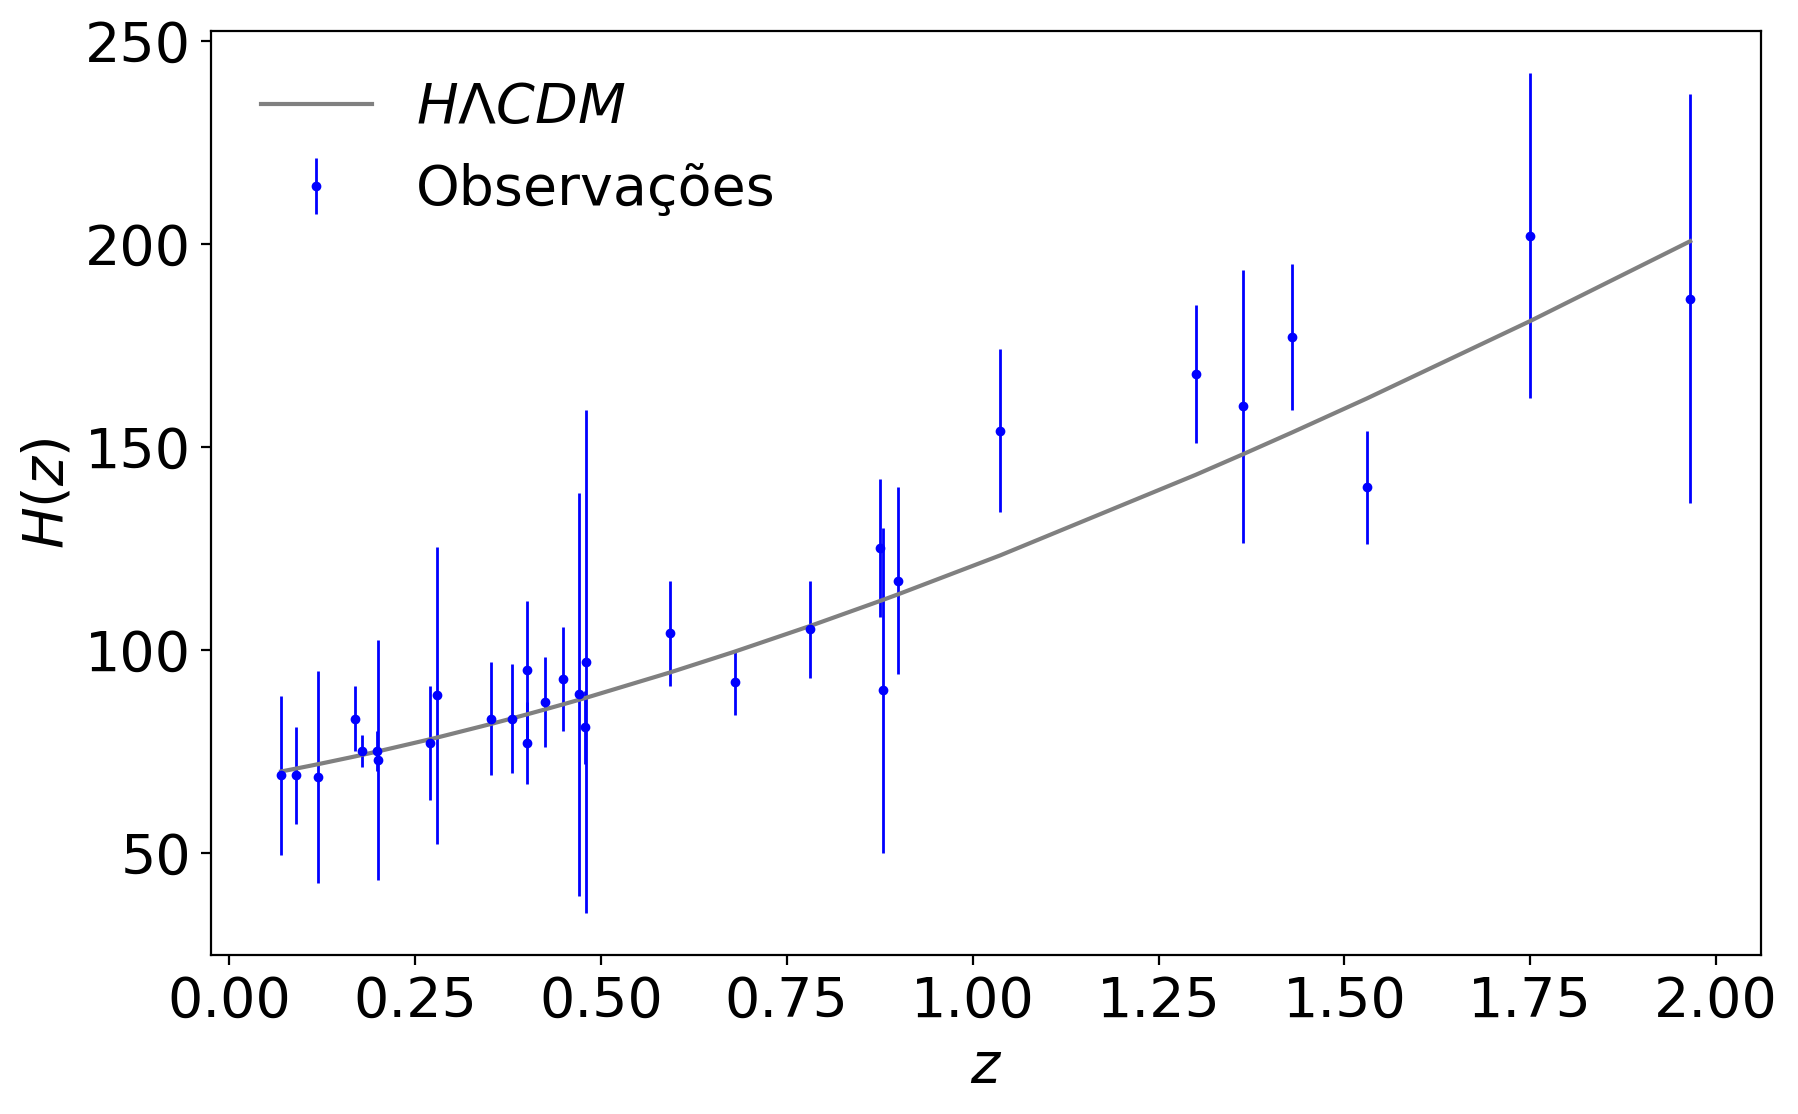

In [23]:
#Definiçaõ das Dimensões dos Gráficos
fig, ax = plt.subplots(figsize =(10,6))


ax.errorbar(z_data, H_data, yerr=z_error, fmt='.', label='Observações', c = "b",ms=5, lw=1)
ax.plot(z_data, StandardModel(z_data, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')
ax.legend(frameon=False, loc=2)
ax.set_xlabel("$z$"), ax.set_ylabel("$H(z)$")

- Plotting do Modelo Padrão $\Lambda CDM$ com sobreposição do Método dos Mínimos Quadrados

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_22451/446086789.py:5: SyntaxWarning: invalid escape sequence '\L'
  ax.plot(z_data, StandardModel(z_data, H0_true, Omega_m0_true), label='Modelo $\Lambda CDM$', c='gray')


Text(0, 0.5, '$H(z)$')

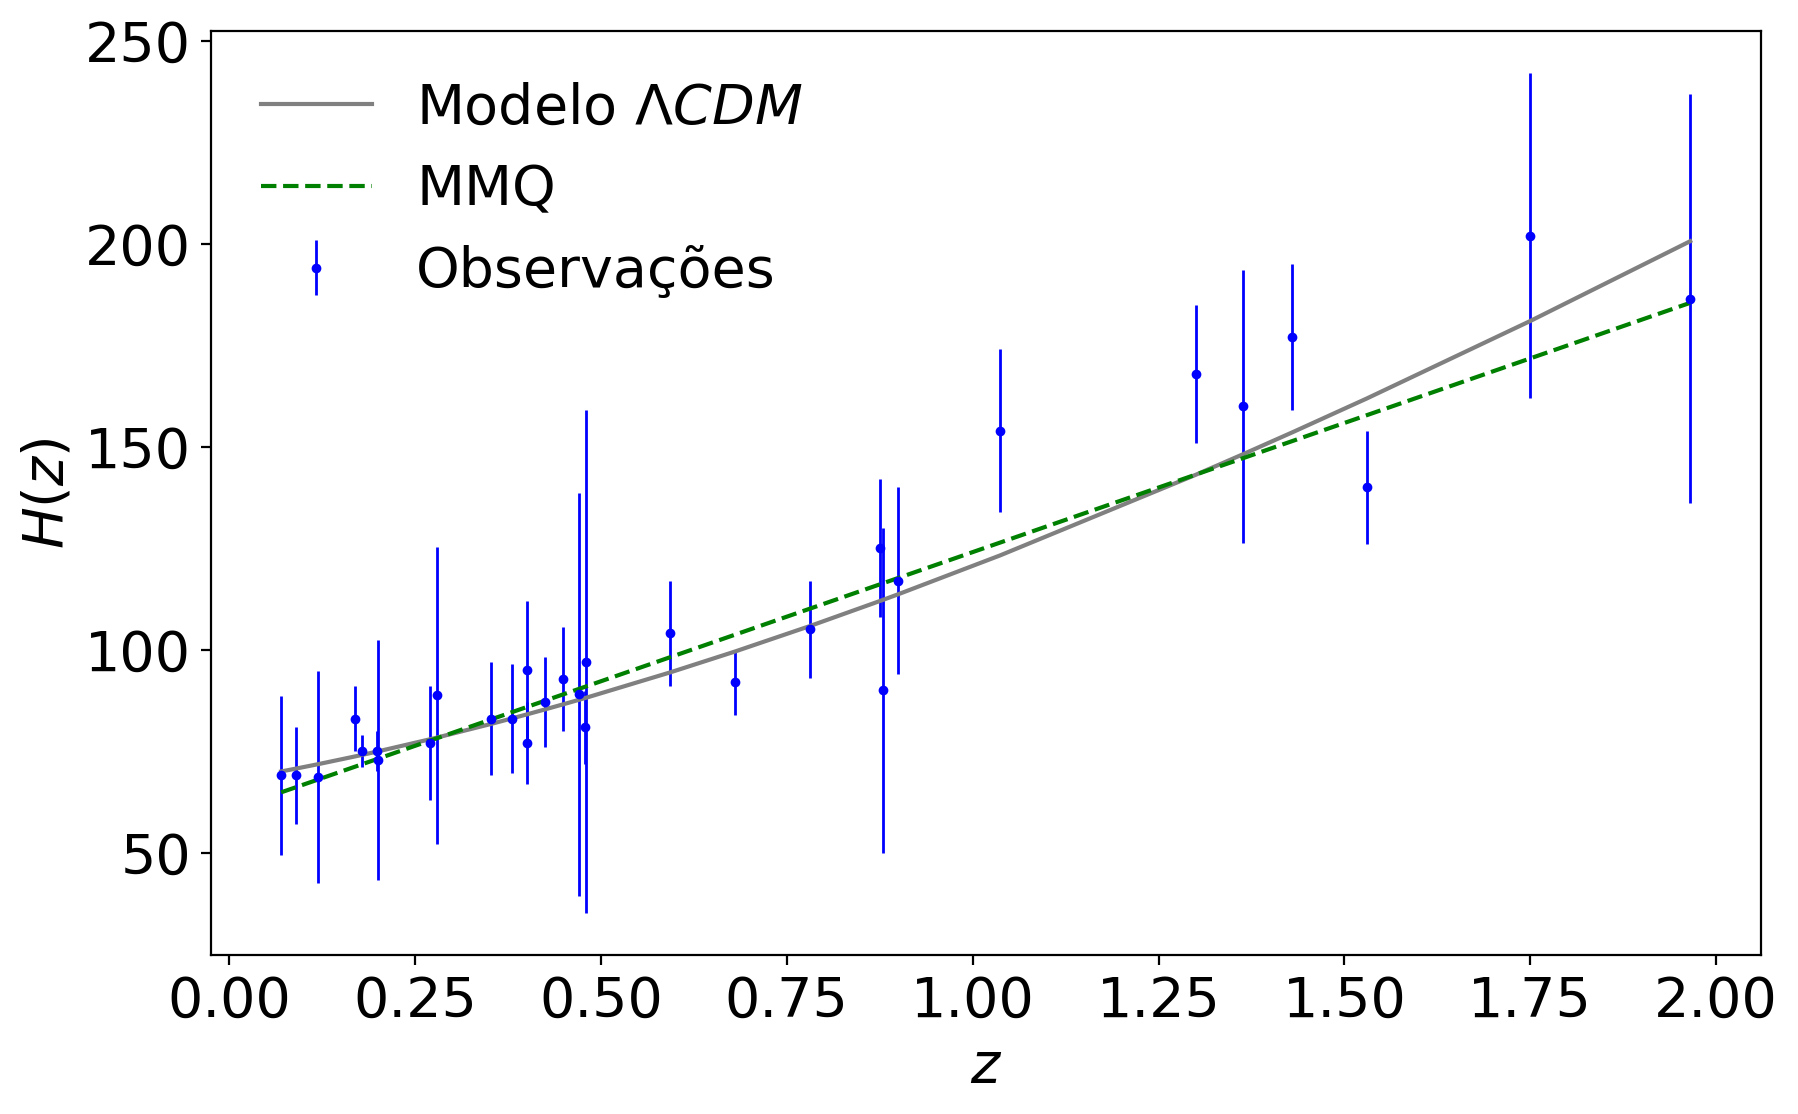

In [25]:
#Definiçaõ das Dimensões dos Gráficos
fig, ax = plt.subplots(figsize =(10,6))

ax.errorbar(z_data, H_data, yerr=z_error, fmt='.', label='Observações', c='b', ms=5, lw=1)
ax.plot(z_data, StandardModel(z_data, H0_true, Omega_m0_true), label='Modelo $\Lambda CDM$', c='gray')
ax.plot(z_data, np.dot(np.vander(z_data,2), w), '--', c='green', label='MMQ')
plt.legend(frameon=False, loc=2)
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')

- Plotting do Modelo $\Lambda CDM$ com sobreposição do modelo com parâmetros obtidos pelo Método de Mínimos Quadrados + modelo com parâmetros obtidos pelo Teste de $\Chi^2$

(Text(0.5, 0, '$z$'), Text(0, 0.5, '$H_0$'))

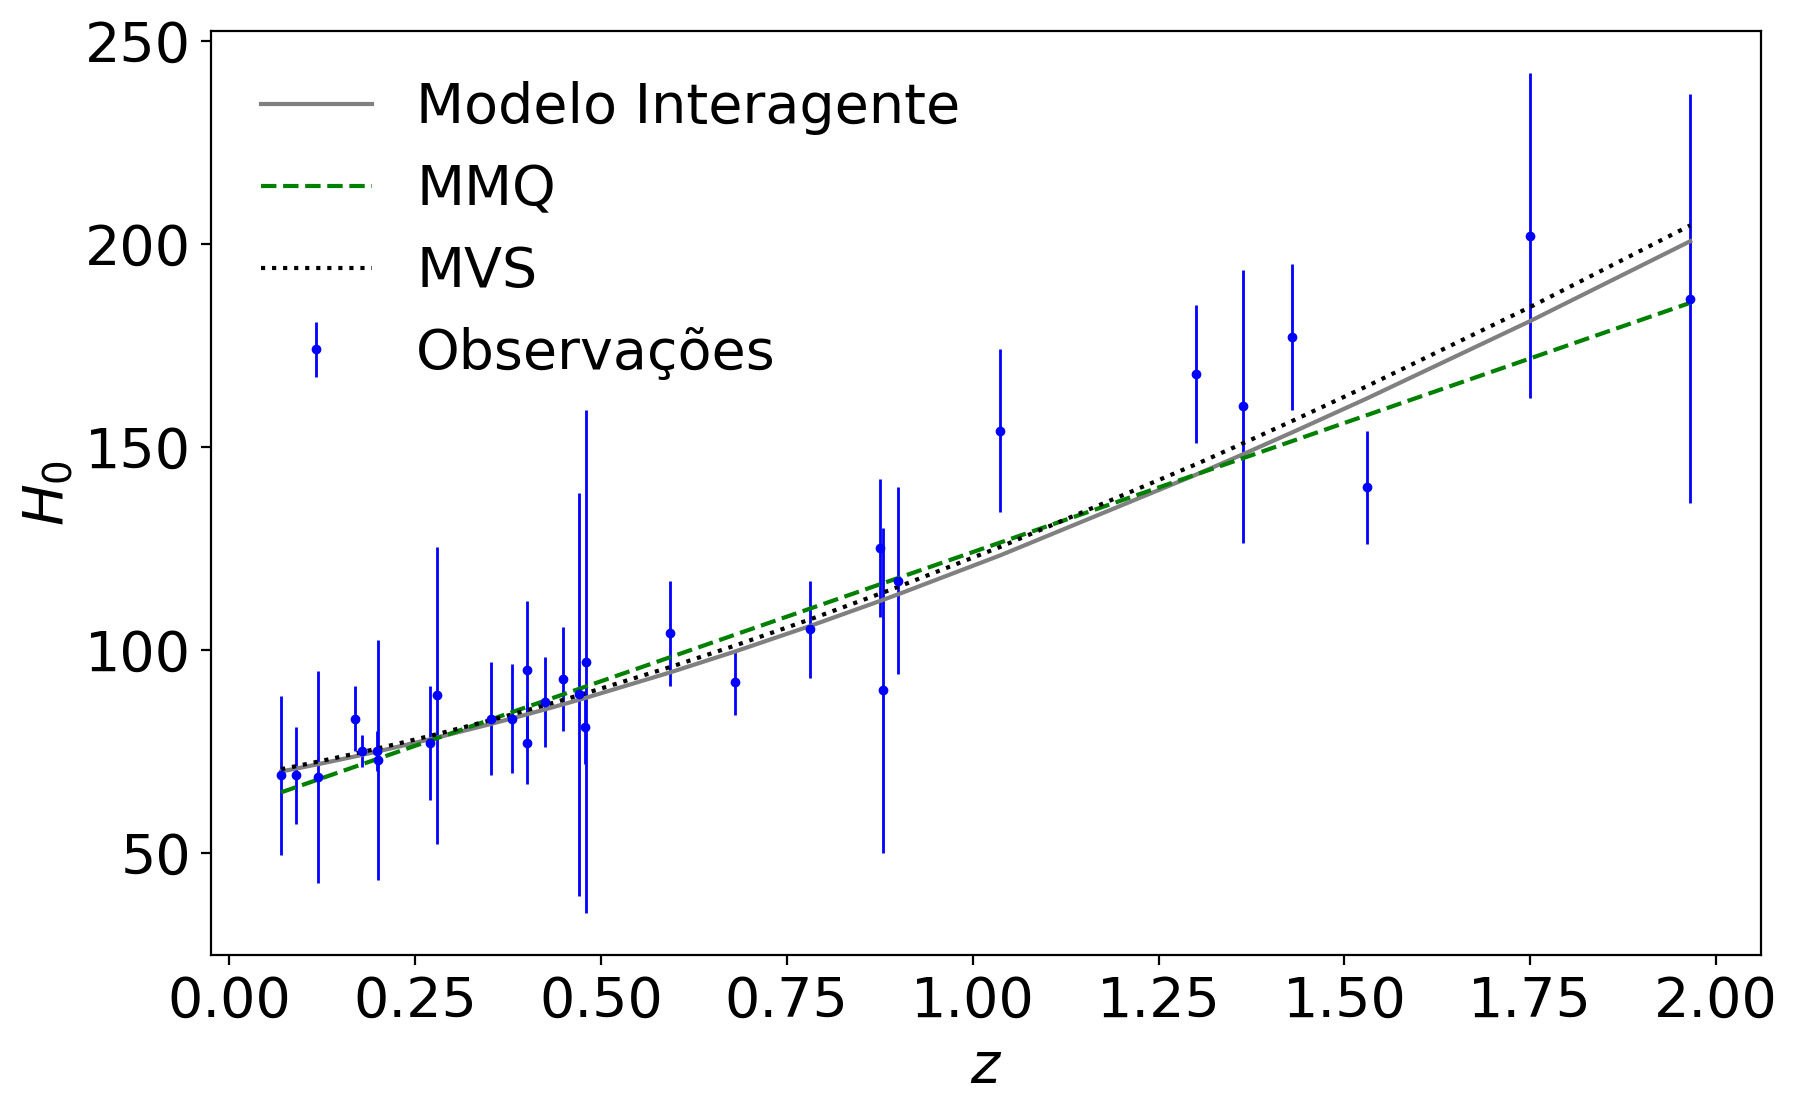

In [27]:
#Definiçaõ das Dimensões dos Gráficos
fig, ax = plt.subplots(figsize =(10,6))

ax.errorbar(z_data, H_data, yerr=z_error, fmt='.', label='Observações',c = "b", ms=5, lw=1)
ax.plot(z_data, StandardModel(z_data, H0_true, Omega_m0_true), label="Modelo Interagente", c='gray')
ax.plot(z_data, np.dot(np.vander(z_data,2), w), "--",c = 'green',  label='MMQ')
ax.plot(z_data, StandardModel(z_data, H0_ml, Omega_ml), ":",c = "black", label="MVS")
ax.legend(frameon=False, loc=2)
ax.set_xlabel("$z$"), ax.set_ylabel("$H_0$")